In [229]:
import numpy as np
import os 
import time
from scipy.signal import savgol_filter
import colour

# My custom library of photoelastic tools
import sys
sys.path.append('/eno/jdfeathe/pepe/')
#sys.path.append('/home/jack//workspaces/jupyter-workspace/pepe/')

from pepe.auto import Trial
from pepe.preprocess import checkImageType, circularMask
from pepe.simulate import genSyntheticResponse
from pepe.visualize import visCircles
from pepe.analysis import derivative

import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 250
plt.rcParams["font.size"] = 18
plt.rcParams["font.family"] = 'stix'
plt.rcParams["image.cmap"] = 'plasma'

In [2]:
# Load in a sample trial
syntheticFolder = '../'
dataset = '2022-04-29_100_MHS_Gap2_0_Synthetic'

trial = Trial(syntheticFolder + dataset)
trial.fixAllNan()

In [3]:
trial.settings

{'imageDirectory': '/eno/jdfeathe/DATA/SpaceJam/2022-04-29_100_MHS_Gap1_0/',
 'imageExtension': 'bmp',
 'imageEndIndex': None,
 'imageStartIndex': None,
 'carryOverAlpha': True,
 'carryOverForce': True,
 'showProgressBar': True,
 'lightCorrectionImage': '/eno/jdfeathe/DATA/SpaceJam/calibration/2022-04-29_Calibration.bmp',
 'lightCorrectionVerticalMask': '/eno/jdfeathe/SpaceJam/masks/2022-04-29_VerticalMask.bmp',
 'lightCorrectionHorizontalMask': '/eno/jdfeathe/SpaceJam/masks/2022-04-29_HorizontalMask.bmp',
 'g2CalibrationImage': '/eno/jdfeathe/DATA/SpaceJam/calibration/2022-04-29_G2_Calibration.bmp',
 'g2CalibrationCutoffFactor': 2.0,
 'maskImage': './masks/2022-04-29_FullMask.bmp',
 'cropXMin': 200,
 'cropXMax': 1200,
 'circleDetectionMethod': 'convolution',
 'guessRadius': 160.0,
 'fSigma': 140.0,
 'pxPerMeter': 21333.333333333336,
 'brightfield': False,
 'contactPadding': 30,
 'g2MaskPadding': 2,
 'contactMaskRadius': 40,
 'peBlurKernel': 2,
 'requireForceBalance': False,
 'circleTr

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


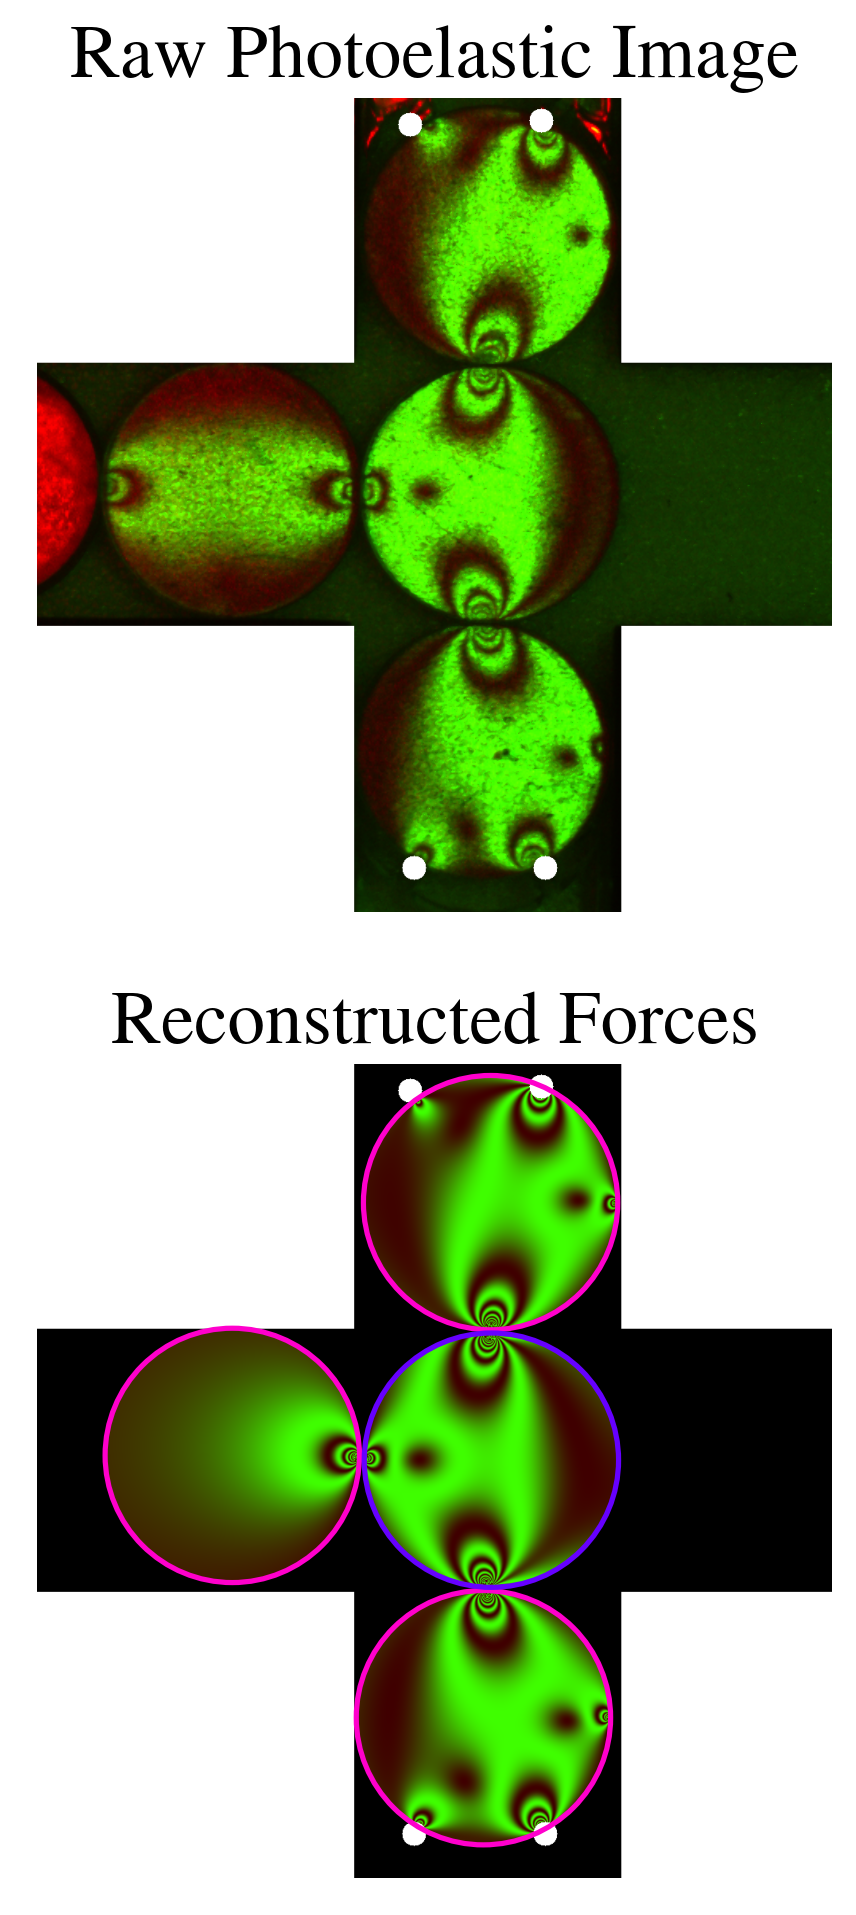

In [230]:
# Load in an image
sampleIndex = 300

# Color the particles the same as in the diagram
purpleColor = str(colour.Color(rgb=(102/255, 0, 255/255)))
pinkColor = str(colour.Color(rgb=(255/255, 0, 204/255)))

topIndex = trial.particleNear([200, 500])
centerIndex = trial.particleNear([500, 500])
driverIndex = trial.particleNear([500, 800])
bottomIndex = trial.particleNear([800, 500])

circleIndices = [topIndex, driverIndex, bottomIndex, centerIndex]
circleColors = [pinkColor, pinkColor, pinkColor, purpleColor]

image = checkImageType(f'{trial.settings["imageDirectory"]}frame0{sampleIndex}.bmp')[:,trial.settings["cropXMin"]:trial.settings["cropXMax"]]
maskArr = checkImageType('../' + trial.settings["maskImage"])[:,trial.settings["cropXMin"]:trial.settings["cropXMax"]]

# Convert to rgba so we can get transparency
transImage = np.ones((*image.shape[:2], 4), dtype=image.dtype)
transImage[:,:,:3] = image
transImage[:,:,3] = maskArr[:,:,0]*255

# Create the synthetic image from the data
synImage = np.zeros(transImage.shape)

for i in circleIndices:
    synImage[:,:,1] += genSyntheticResponse(trial.forceArr[i][:,sampleIndex],
                                     trial.alphaArr[i][:,sampleIndex],
                                     trial.betaArr[i][:,sampleIndex],
                                     trial.settings["fSigma"], trial.radiusArr[i,sampleIndex],
                                     trial.settings["pxPerMeter"], trial.settings["brightfield"],
                                     imageSize=image.shape[:2], center=np.int64(trial.centerArr[i,sampleIndex]))

for i in circleIndices:
    synImage[:,:,0] += circularMask(synImage.shape[:2], trial.centerArr[i,sampleIndex], trial.radiusArr[i,sampleIndex])[:,:,0] * .25
    
synImage[:,:,3] = maskArr[:,:,0]*255

fig, ax = plt.subplots(2, 1, figsize=(5.5,8))
    
ax[0].imshow(transImage)
#ax[0].imshow(image * maskArr + (1 - maskArr)*(255, 255, 255))
ax[1].imshow(synImage)#, cmap='summer')# 
visCircles(trial.centerArr[circleIndices,sampleIndex,:],
           trial.radiusArr[circleIndices,sampleIndex], ax=ax[1],
           colors=circleColors, linewidth=1.5)

for i in range(2):
    ax[i].invert_xaxis()
    ax[i].invert_yaxis()
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].spines['bottom'].set_color('#00000000')
    ax[i].spines['top'].set_color('#00000000') 
    ax[i].spines['right'].set_color('#00000000')
    ax[i].spines['left'].set_color('#00000000')
    
ax[0].set_title('Raw Photoelastic Image')
ax[1].set_title('Reconstructed Forces')
    
fig.tight_layout()
plt.savefig('../images/synthetic_comparison.png', transparent=True)
plt.show()

In [50]:
syntheticFolder = '../'
#syntheticFolder = '/eno/jdfeathe/DATA/SpaceJam_Synthetic/'
dataKey = '2022-04-29_'
radius = 160

fileList = os.listdir(syntheticFolder)

fileList = np.sort([f for f in fileList if dataKey in f and not 'NoAir' in f])
#fileList = fileList[:3]

speedArr = [float(f.split('_')[1]) for f in fileList]
stiffnessArr = [f.split('_')[2] for f in fileList]

trials = [None]*len(fileList)

for i in range(len(fileList)):
    trials[i] = Trial(syntheticFolder + fileList[i])
    trials[i].fixAllNan()

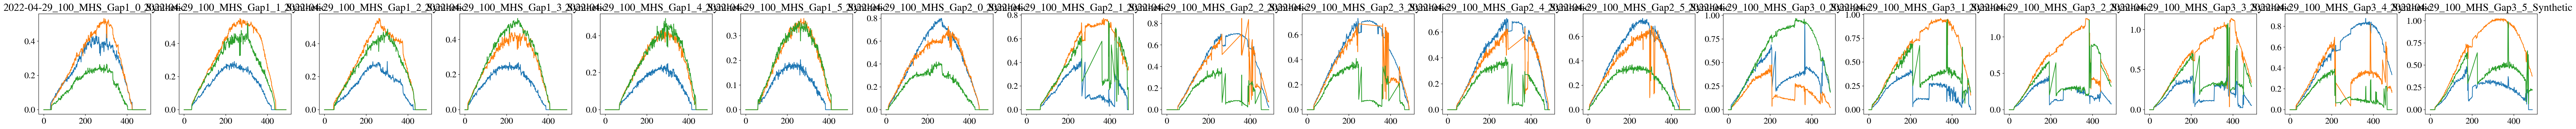

In [52]:
fig, ax = plt.subplots(1, len(trials), figsize=(len(trials)*4, 4))

for i in range(len(trials)):
    centralParticle = trials[i].particleNear([500, 500])
    for j in range(trials[i].numForces[centralParticle]):
        ax[i].plot(trials[i].forceArr[centralParticle][j])
        
    ax[i].set_title(str(trials[i]))
    
fig.tight_layout()
plt.show()

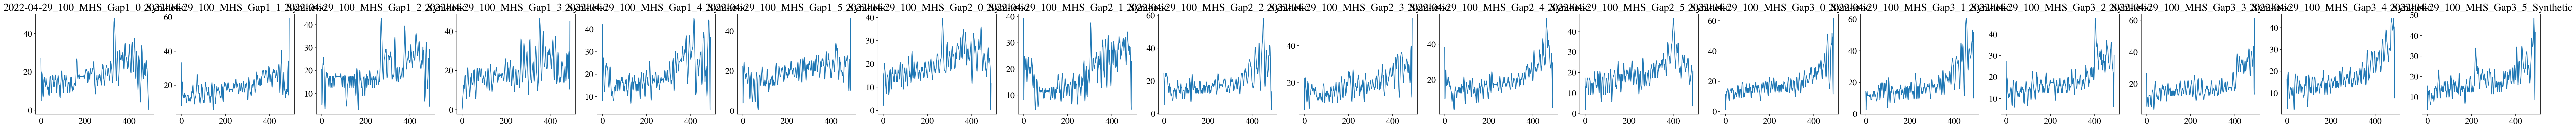

In [64]:
fig, ax = plt.subplots(1, len(trials), figsize=(len(trials)*4, 4))

for i in range(len(trials)):
    centralParticle = trials[i].particleNear([500, 500])
    ax[i].plot(np.abs(savgol_filter(derivative(savgol_filter(trials[i].centerArr[centralParticle,:,1], 11, 2), 1/70), 11, 3)))
        
    ax[i].set_title(str(trials[i]))
    
fig.tight_layout()
plt.show()

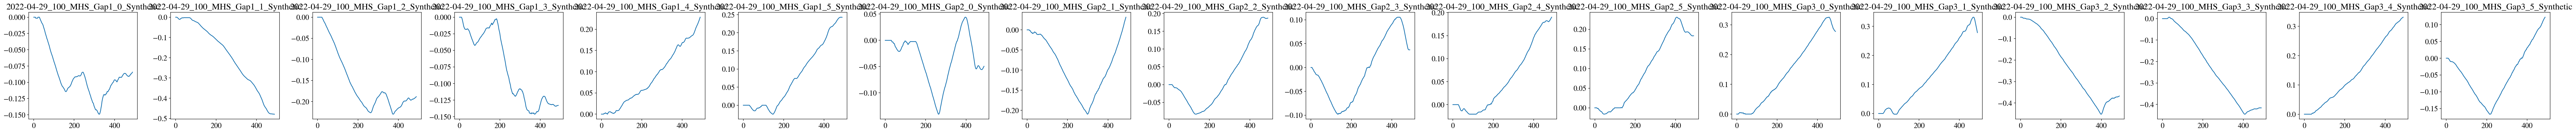

In [170]:
fig, ax = plt.subplots(1, len(trials), figsize=(len(trials)*4, 4))

for i in range(len(trials)):
    centralParticle = trials[i].particleNear([500, 500])
    ax[i].plot(savgol_filter(trials[i].angleArr[centralParticle], 11, 1))
        
    ax[i].set_title(str(trials[i]))
    
fig.tight_layout()
plt.show()

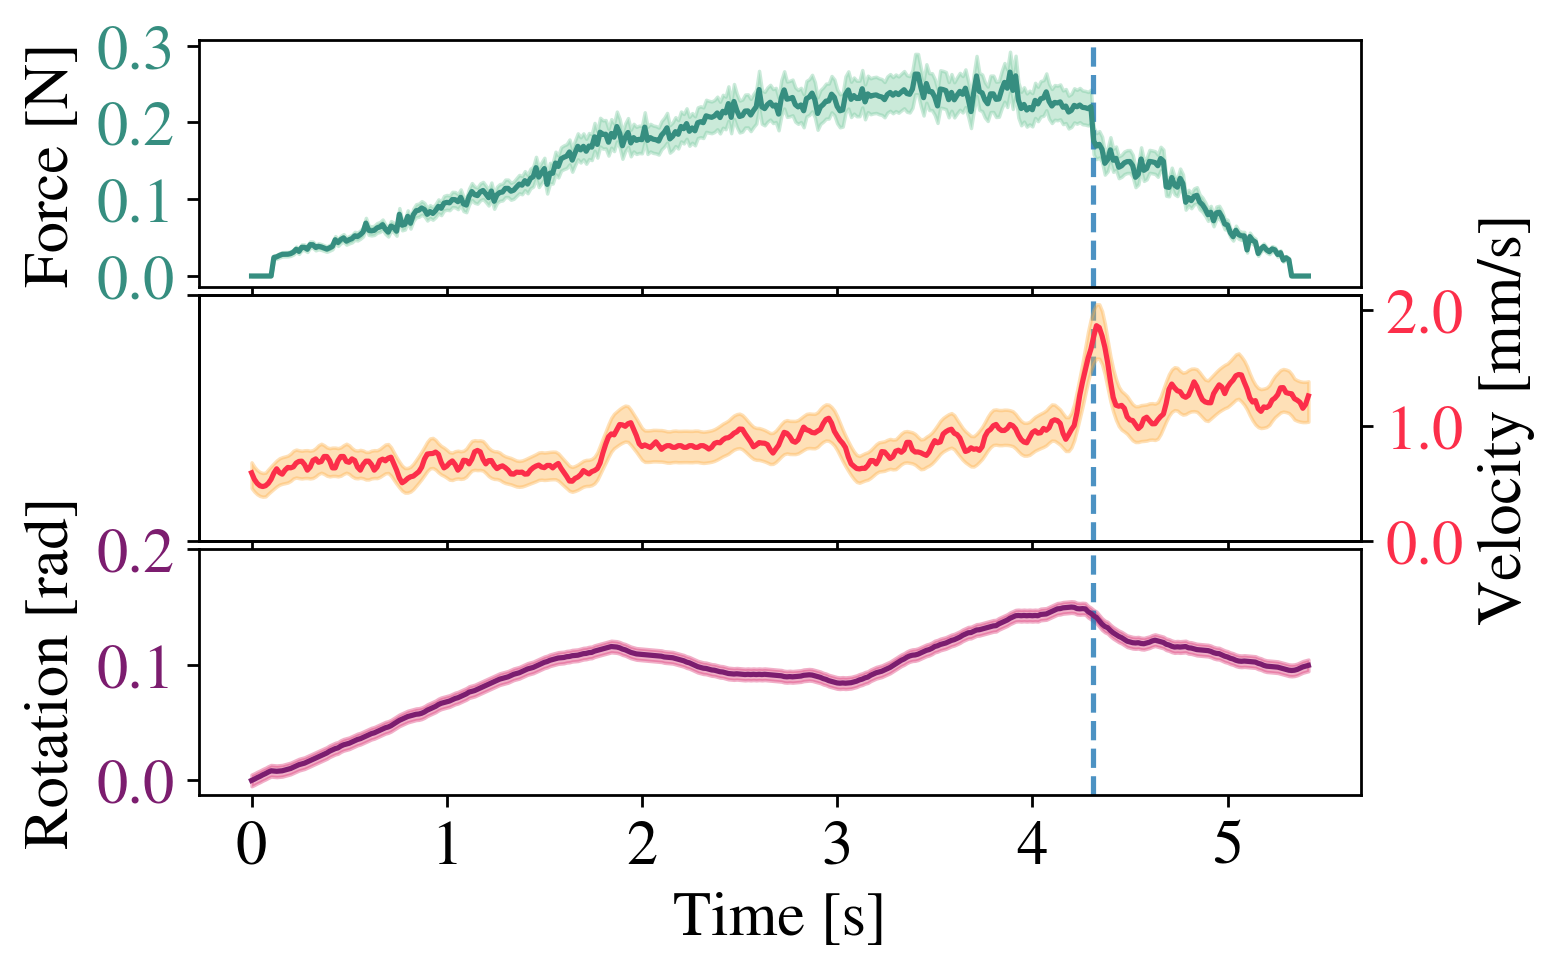

In [243]:
trialChoice = 0

forceColor1 = '#368E80'
forceColor2 = '#7CCBA2'

velocityColor1 = '#FC2E4A'
velocityColor2 = '#FEB24C'

angleColor1 = '#7C1D6F'
angleColor2 = '#DC3977'

centralParticle = trials[trialChoice].particleNear([500, 500])
velocityArr = np.abs(savgol_filter(derivative(savgol_filter(trials[trialChoice].centerArr[centralParticle,:,1], 11, 1), 1/70), 11, 2))[30:-80]

velocityArr = velocityArr / trials[trialChoice].settings["pxPerMeter"] * 1e3

# Assuming error of 1 pixel in circle identification
error = 1 / 2*radius * 1/70 / trials[trialChoice].settings["pxPerMeter"] * 1e3
# Tack on 5% from the smoothing
error += velocityArr*.1

upperFill = savgol_filter(velocityArr + error, 11, 2)
lowerFill = savgol_filter(velocityArr - error, 11, 2)

#upperFill = (upperFill[1:] + upperFill[:-1]) / 2
#lowerFill = (lowerFill[1:] + lowerFill[:-1]) / 2

#fig, ax = plt.subplots(3, 1, figsize=(7,6), sharex=True)
fig = plt.figure()
gs = fig.add_gridspec(3, 1, hspace=.03, wspace=0)
ax = gs.subplots(sharex='col', sharey='row')

forceArr = trials[trialChoice].forceArr[centralParticle][2][30:-80]
forceError = forceArr * .1

angleArr = savgol_filter(trials[trialChoice].angleArr[centralParticle], 7, 1)[30:-80] * -1
angleError = .005 # See wiki

for i in range(3):
    ax[i].axvline(x=4.31, linestyle='--', alpha=.8, label='Slip')

ax[0].fill_between(np.arange(len(forceArr))/70, forceArr + forceError, forceArr - forceError, alpha=.4, color=forceColor2)
ax[0].plot(np.arange(len(forceArr))/70, forceArr, c=forceColor1)

ax[0].set_ylabel('Force [N]')
ax[0].set_yticks([0.0, 0.1, 0.2, 0.3], [0.0, 0.1, 0.2, 0.3])
ax[0].tick_params(axis='y', labelcolor=forceColor1)
#ax[0].legend()

#ax[0].set_yticks([-.2, -.1, 0, .1, .2, .3], [None, None, 0.0, 0.1, 0.2, 0.3])
ax[1].tick_params(axis='y', labelcolor='#00000000')
ax[1] = ax[1].twinx()

ax[1].fill_between(np.arange(len(velocityArr))/70, upperFill, lowerFill, alpha=.4, color=velocityColor2)
ax[1].plot(np.arange(len(velocityArr))/70, velocityArr, c=velocityColor1)

#ax[1].set_ylim([0, 4.])
ax[1].set_yticks([0, 1, 2], [0.0, 1.0, 2.0])
ax[1].set_ylabel('Velocity [mm/s]')
ax[1].tick_params(axis='y', labelcolor=velocityColor1)

ax[2].fill_between(np.arange(len(angleArr))/70, angleArr + angleError, angleArr - angleError, alpha=.4, color=angleColor2)
ax[2].plot(np.arange(len(angleArr))/70, angleArr, c=angleColor1)
ax[2].set_ylabel('Rotation [rad]')
ax[2].set_yticks([0.0, 0.1, 0.2], [0.0, 0.1, 0.2])
ax[2].tick_params(axis='y', labelcolor=angleColor1)

ax[-1].set_xlabel('Time [s]')

plt.savefig('../images/failure_stick_slip.png', bbox_inches="tight")
plt.show()

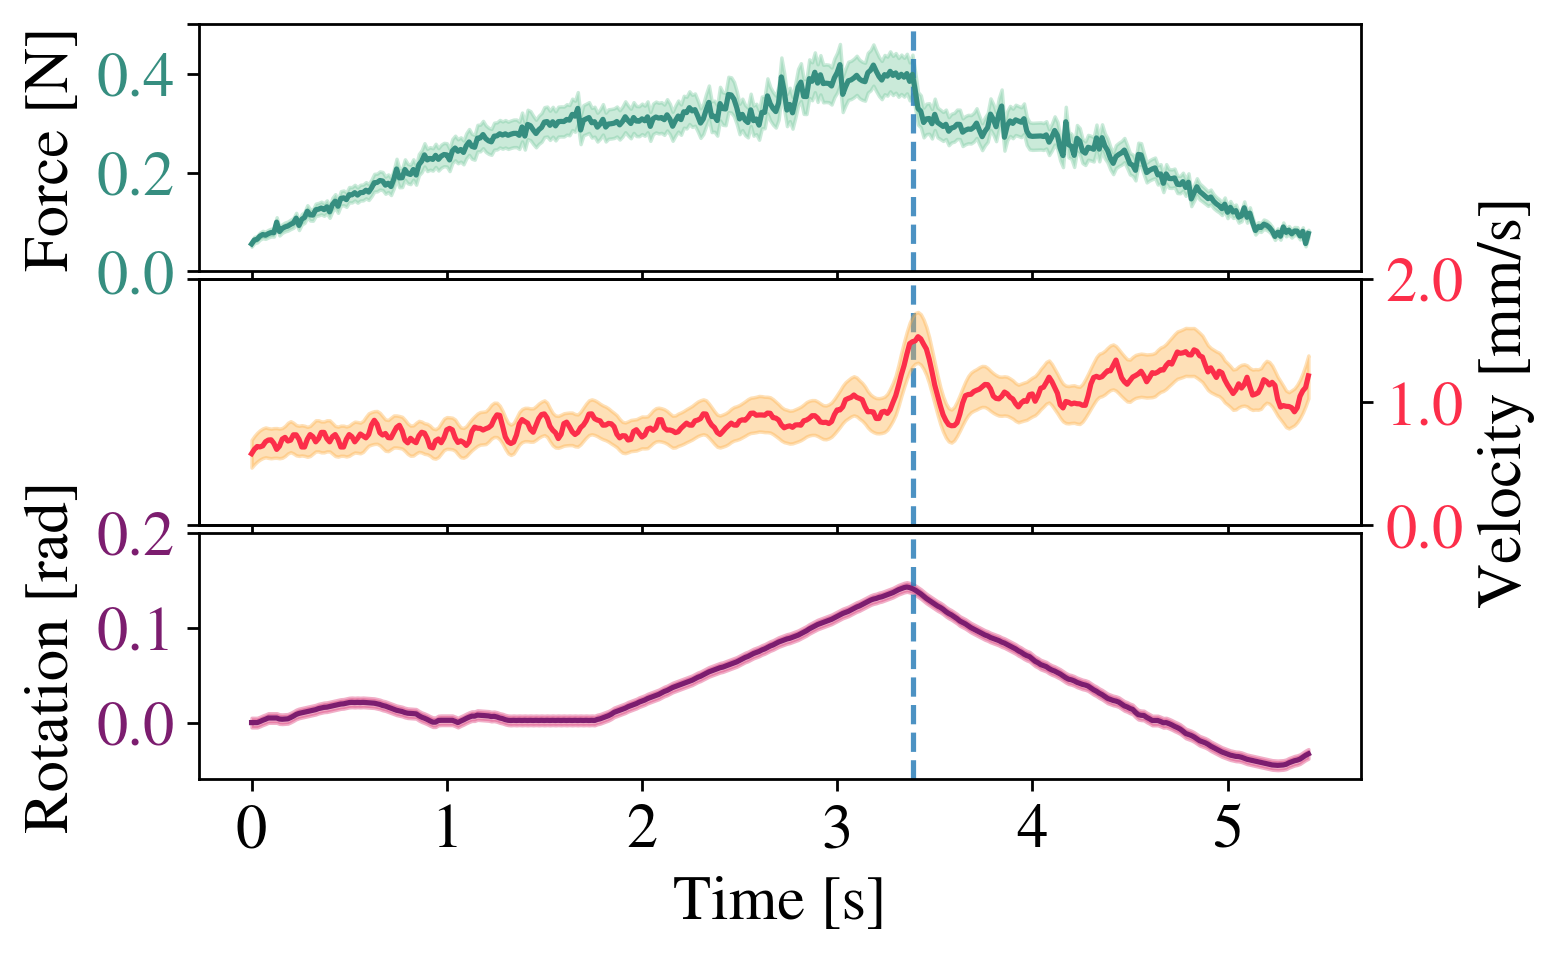

In [244]:
trialChoice = 6

forceColor1 = '#368E80'
forceColor2 = '#7CCBA2'

velocityColor1 = '#FC2E4A'
velocityColor2 = '#FEB24C'

angleColor1 = '#7C1D6F'
angleColor2 = '#DC3977'

centralParticle = trials[trialChoice].particleNear([500, 500])
velocityArr = np.abs(savgol_filter(derivative(savgol_filter(trials[trialChoice].centerArr[centralParticle,:,1], 11, 1), 1/70), 11, 2))[30:-80]

velocityArr = velocityArr / trials[trialChoice].settings["pxPerMeter"] * 1e3

# Assuming error of 1 pixel in circle identification
error = 1 / 2*radius * 1/70 / trials[trialChoice].settings["pxPerMeter"] * 1e3
# Tack on 5% from the smoothing
error += velocityArr*.1

upperFill = savgol_filter(velocityArr + error, 11, 2)
lowerFill = savgol_filter(velocityArr - error, 11, 2)

#upperFill = (upperFill[1:] + upperFill[:-1]) / 2
#lowerFill = (lowerFill[1:] + lowerFill[:-1]) / 2

#fig, ax = plt.subplots(3, 1, figsize=(7,6), sharex=True)
fig = plt.figure()
gs = fig.add_gridspec(3, 1, hspace=.03, wspace=0)
ax = gs.subplots(sharex='col', sharey='row')

forceArr = trials[trialChoice].forceArr[centralParticle][2][30:-80]
forceError = forceArr * .1

angleArr = savgol_filter(trials[trialChoice].angleArr[centralParticle], 7, 1)[30:-80] * -1
angleError = .005 # See wiki

for i in range(3):
    ax[i].axvline(x=3.39, linestyle='--', alpha=.8, label='Slip')

ax[0].fill_between(np.arange(len(forceArr))/70, forceArr + forceError, forceArr - forceError, alpha=.4, color=forceColor2)
ax[0].plot(np.arange(len(forceArr))/70, forceArr, c=forceColor1)

ax[0].set_ylabel('Force [N]')
ax[0].set_yticks([0.0, 0.2, 0.4, 0.5], [0.0, 0.2, 0.4, None])
ax[0].tick_params(axis='y', labelcolor=forceColor1)
#ax[0].legend(loc='upper left')

#ax[0].set_yticks([-.2, -.1, 0, .1, .2, .3], [None, None, 0.0, 0.1, 0.2, 0.3])
ax[1].tick_params(axis='y', labelcolor='#00000000')
ax[1] = ax[1].twinx()

ax[1].fill_between(np.arange(len(velocityArr))/70, upperFill, lowerFill, alpha=.4, color=velocityColor2)
ax[1].plot(np.arange(len(velocityArr))/70, velocityArr, c=velocityColor1)

#ax[1].set_ylim([0, 4.])
ax[1].set_yticks([0, 1, 2], [0.0, 1.0, 2.0])
ax[1].set_ylabel('Velocity [mm/s]')
ax[1].tick_params(axis='y', labelcolor=velocityColor1)

ax[2].fill_between(np.arange(len(angleArr))/70, angleArr + angleError, angleArr - angleError, alpha=.4, color=angleColor2)
ax[2].plot(np.arange(len(angleArr))/70, angleArr, c=angleColor1)
ax[2].set_ylabel('Rotation [rad]')
ax[2].set_yticks([0.0, 0.1, 0.2], [0.0, 0.1, 0.2])
ax[2].tick_params(axis='y', labelcolor=angleColor1)

ax[-1].set_xlabel('Time [s]')

plt.savefig('../images/failure_stick_slip_2.png', bbox_inches="tight")
plt.show()

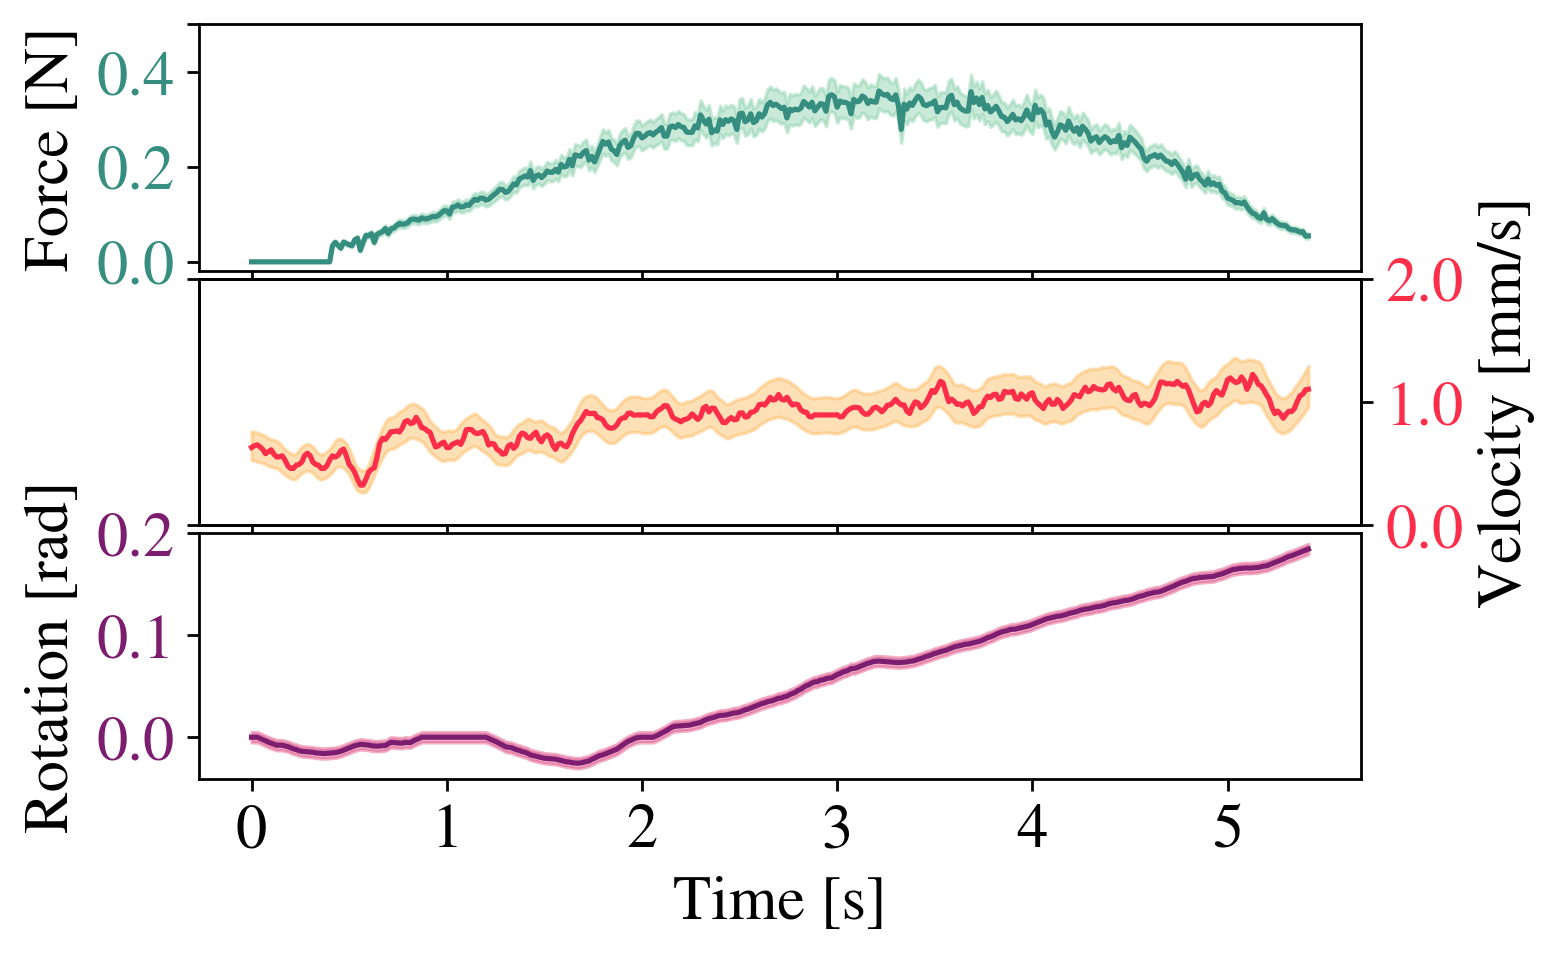

In [245]:
trialChoice = 5

forceColor1 = '#368E80'
forceColor2 = '#7CCBA2'

velocityColor1 = '#FC2E4A'
velocityColor2 = '#FEB24C'

angleColor1 = '#7C1D6F'
angleColor2 = '#DC3977'

centralParticle = trials[trialChoice].particleNear([500, 500])
velocityArr = np.abs(savgol_filter(derivative(savgol_filter(trials[trialChoice].centerArr[centralParticle,:,1], 11, 1), 1/70), 11, 2))[30:-80]

velocityArr = velocityArr / trials[trialChoice].settings["pxPerMeter"] * 1e3

# Assuming error of 1 pixel in circle identification
error = 1 / 2*radius * 1/70 / trials[trialChoice].settings["pxPerMeter"] * 1e3
# Tack on 5% from the smoothing
error += velocityArr*.1

upperFill = savgol_filter(velocityArr + error, 11, 2)
lowerFill = savgol_filter(velocityArr - error, 11, 2)

#upperFill = (upperFill[1:] + upperFill[:-1]) / 2
#lowerFill = (lowerFill[1:] + lowerFill[:-1]) / 2

#fig, ax = plt.subplots(3, 1, figsize=(7,6), sharex=True)
fig = plt.figure()
gs = fig.add_gridspec(3, 1, hspace=.03, wspace=0)
ax = gs.subplots(sharex='col', sharey='row')

forceArr = trials[trialChoice].forceArr[centralParticle][2][30:-80]
forceError = forceArr * .1

angleArr = savgol_filter(trials[trialChoice].angleArr[centralParticle], 7, 1)[30:-80]
angleError = .005 # See wiki

ax[0].fill_between(np.arange(len(forceArr))/70, forceArr + forceError, forceArr - forceError, alpha=.4, color=forceColor2)
ax[0].plot(np.arange(len(forceArr))/70, forceArr, c=forceColor1)

ax[0].set_ylabel('Force [N]')
ax[0].set_yticks([0.0, 0.2, 0.4, 0.5], [0.0, 0.2, 0.4, None])
ax[0].tick_params(axis='y', labelcolor=forceColor1)

#ax[0].set_yticks([-.2, -.1, 0, .1, .2, .3], [None, None, 0.0, 0.1, 0.2, 0.3])
ax[1].tick_params(axis='y', labelcolor='#00000000')
ax[1] = ax[1].twinx()

ax[1].fill_between(np.arange(len(velocityArr))/70, upperFill, lowerFill, alpha=.4, color=velocityColor2)
ax[1].plot(np.arange(len(velocityArr))/70, velocityArr, c=velocityColor1)

#ax[1].set_ylim([0, 4.])
ax[1].set_yticks([0, 1, 2], [0.0, 1.0, 2.0])
ax[1].set_ylabel('Velocity [mm/s]')
ax[1].tick_params(axis='y', labelcolor=velocityColor1)

ax[2].fill_between(np.arange(len(angleArr))/70, angleArr + angleError, angleArr - angleError, alpha=.4, color=angleColor2)
ax[2].plot(np.arange(len(angleArr))/70, angleArr, c=angleColor1)
ax[2].set_ylabel('Rotation [rad]')
ax[2].set_yticks([0.0, 0.1, 0.2], [0.0, 0.1, 0.2])
ax[2].tick_params(axis='y', labelcolor=angleColor1)

ax[-1].set_xlabel('Time [s]')

plt.savefig('../images/failure_creep.png', bbox_inches="tight")
plt.show()